In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    'Num cells x1': load_data('../stats/fpm_4_x1.json'),
# #     # 'num cells x64': load_data('../stats/fpm_3_x4.json'),
    'Num cells x8': load_data('../stats/fpm_4_x2.json'),
# #     # 'num cells x125': load_data('../stats/fpm_3_x5.json'),
    # 'Num cells x27': load_data('../stats/fpm_4_x3.json'),
# #     # 'num cells x216': load_data('../stats/fpm_3_x6.json'),
}

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
from fpm_4 import make_model

model = make_model()
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()


num sticking: 0
num sliding: 0
num open: 0
num trans: 64


In [54]:
mat_idx = 4
entry = data['Num cells x8']
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

39


In [55]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

model.assemble_linear_system()
perm_mat, prec_orig = model._prepare_solver()
J = perm_mat[:]

24
40
0
0


Solve  took: 2.41
True residual decrease: 0.009341736759521317


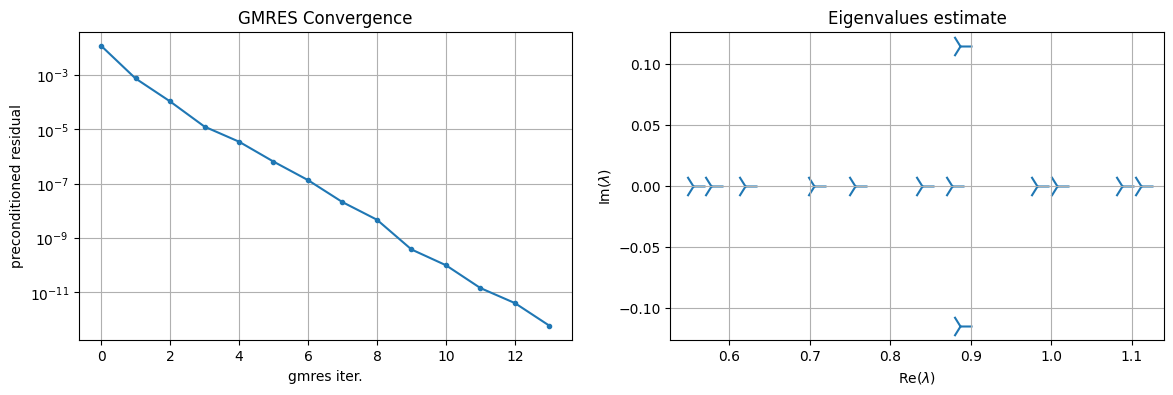

In [57]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

Solve  took: 2.19
True residual decrease: 0.009341738347628758


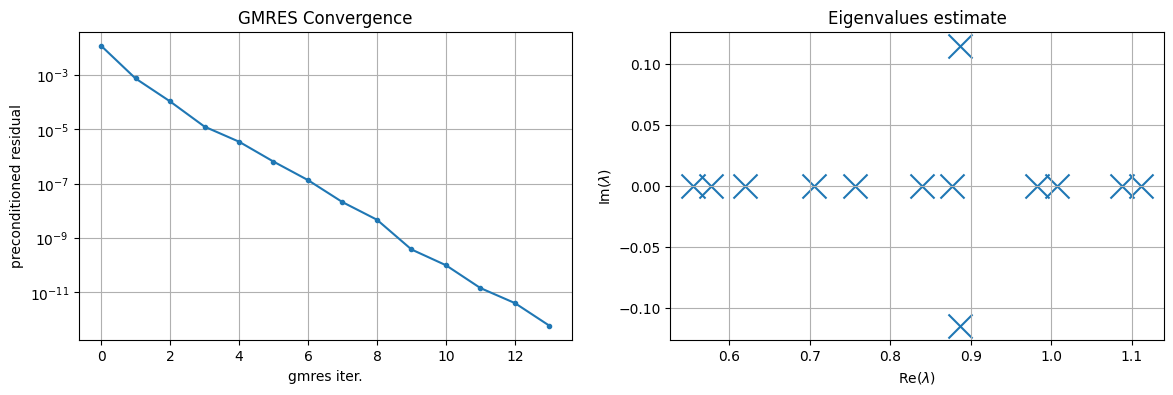

In [58]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: make_J44_inv_bdiag(model, bmat=bmat),
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            # invertor=lambda bmat: make_fs(model, bmat).mat,
            invertor=lambda bmat: model._fixed_stress.mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)

bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=J)
solve_petsc(bmat_reordered.mat, preconditioner, rhs=bmat_reordered.local_rhs(rhs))

In [82]:
bmat = J
J44 = bmat[4,4].mat
J55 = bmat[5,5].mat
# J55_inv = inv_block_diag(J55, nd=model.nd)
J55_inv = inv(J55)
stab = bmat[4, 5].mat @ J55_inv @ bmat[5, 4].mat
st, sl, op, tr = model.sticking_sliding_open_transition()

sliding_tang = np.repeat(sl, model.nd)
sliding_tang[::model.nd] = 0  # we need only tangential
stab[sliding_tang] = 0

sliding_norm = np.repeat(sl, model.nd)
sliding_norm[1::model.nd] = 0
sliding_norm[2::model.nd] = 0

# stab[sliding_norm, 0::3] = 0
# stab[sliding_norm, 1::3] = 0

S44 = J44 - stab

sticking = np.repeat(st, model.nd)
S44[sticking] *= 0.5
S44[sliding_norm] *= 0.5

j45_modified = bmat[4, 5].mat
j45_modified[sticking] *= 0.5
j45_modified[sliding_norm] *= 0.5

In [83]:
J45 = J[[4, 5]].copy().mat
J45_stab = J[[4, 5]].copy()
J45_stab[4, 4] = S44

# J45_stab[4, 5] = j45_modified

cond(inv(J45_stab.mat) @ J45)

1.5389276797132683

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


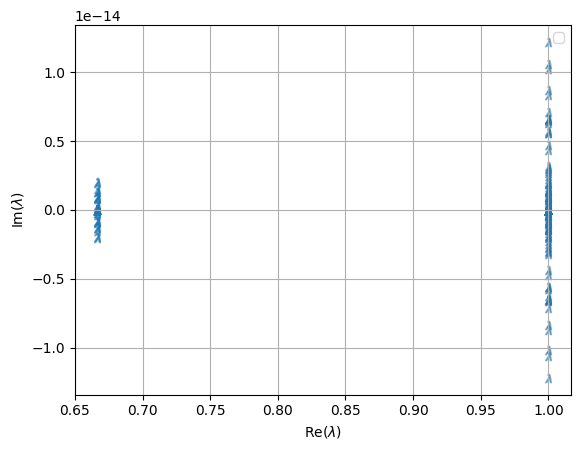

In [84]:
plot_eigs(inv(J45_stab.mat) @ J45)

In [85]:
J_stab = J.copy()
J_stab[4, 4] = S44
J_stab[4, 5] = j45_modified

Solve  took: 14.81
True residual decrease: 0.0018351644460997108


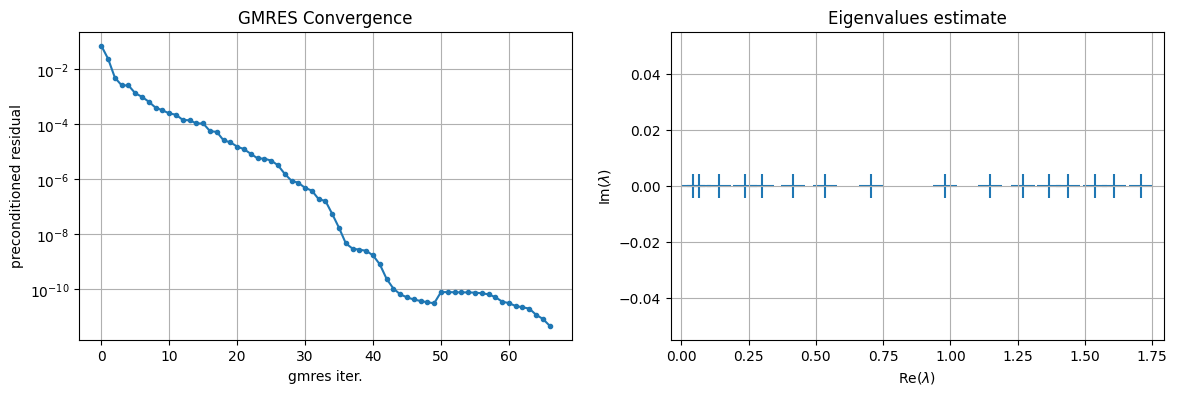

In [86]:
schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(bmat[4, 4].mat, nd=model.nd),
    complement=SolveSchema(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            invertor=lambda bmat: model._fixed_stress.mat,
            invertor_type="physical",
            complement=SolveSchema(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            ),
        ),
    ),
)

bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=J_stab)
bmat_reordered = J[bmat_reordered.active_groups]
solve_petsc(bmat_reordered.mat, preconditioner, rhs=bmat_reordered.local_rhs(rhs))